# Análisis del uso de BART (Bayesian Additive Regression Trees) en la evaluación ACIC 2016
Damián Piuselli y Tomás Korenblit

In [2]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = "retina"


print(f"Running on PyMC v{pm.__version__}")

from statsmodels.api import OLS

Running on PyMC v5.20.1


In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
x_df = pd.read_csv('data/x.csv')
zy_1_df = pd.read_csv('data/zy_1.csv')

In [5]:
x_df.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58
0,29,C,1.0,7.0,60,85,0,0,1,0,...,0,0,0,0,0,0,0,0,45,39
1,27,C,0.0,0.0,64,178,0,0,0,0,...,0,0,0,0,0,0,0,0,46,42
2,27,C,0.0,0.0,60,102,0,0,0,0,...,1,0,0,0,0,0,0,0,45,40
3,37,C,0.0,0.0,65,174,0,0,0,0,...,0,0,0,0,0,0,0,0,47,40
4,24,C,20.0,14.0,63,129,0,0,0,0,...,2,0,0,0,0,0,0,0,47,43


In [6]:
zy_1_df.head()

,z,y
0,1,-46.608596
1,0,-30.484971
2,0,-34.448218
3,0,-32.733195
4,0,-38.920098


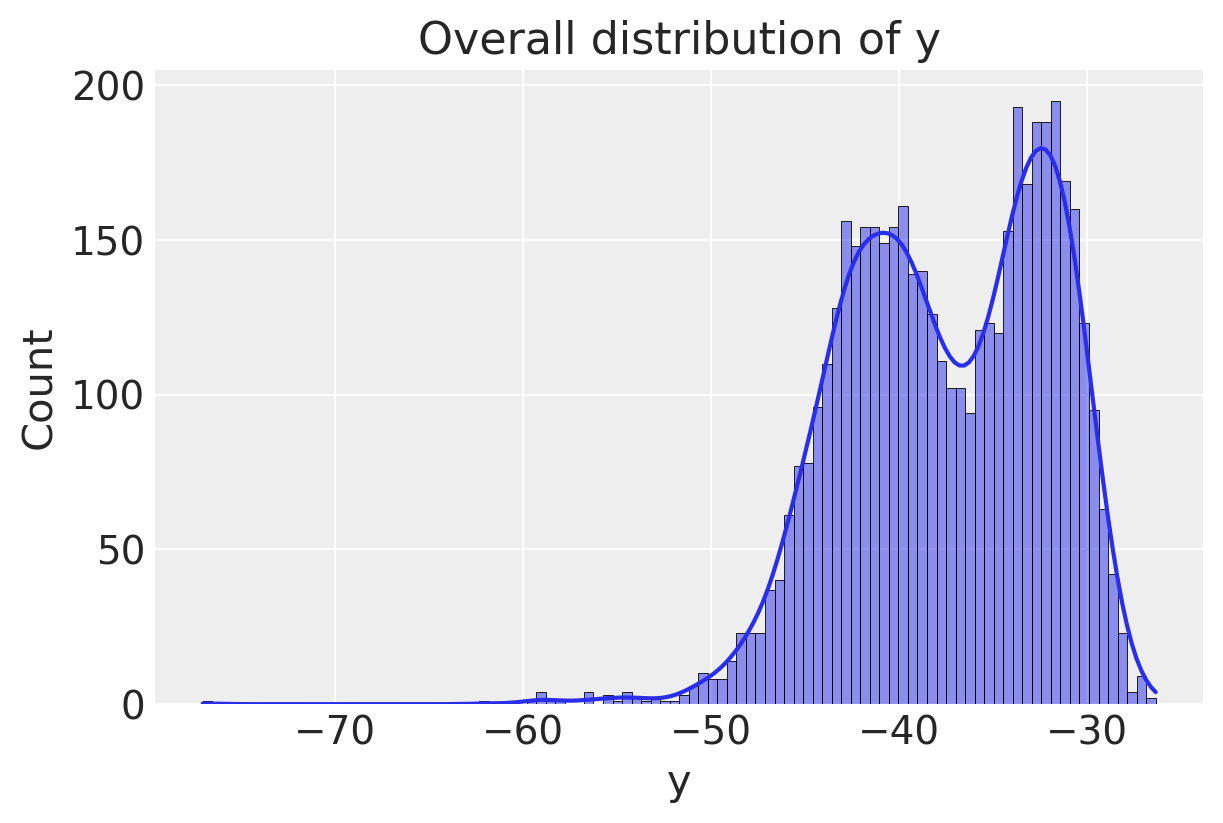

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(zy_1_df['y'], kde=True, bins=100)
plt.title("Overall distribution of y")
plt.xlabel("y")
plt.ylabel("Count")
plt.show()

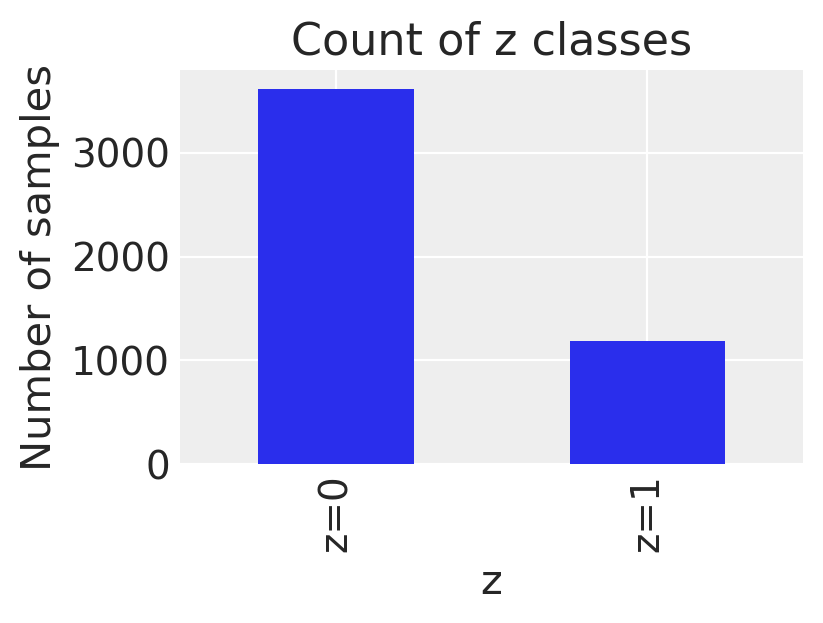

In [9]:
plt.figure(figsize=(4,3))
zy_1_df['z'].value_counts().sort_index().plot.bar()
plt.xticks([0,1], ['z=0','z=1'])
plt.title("Count of z classes")
plt.ylabel("Number of samples")
plt.show()

/opt/homebrew/anaconda3/envs/pymc_new/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x400 with 0 Axes>

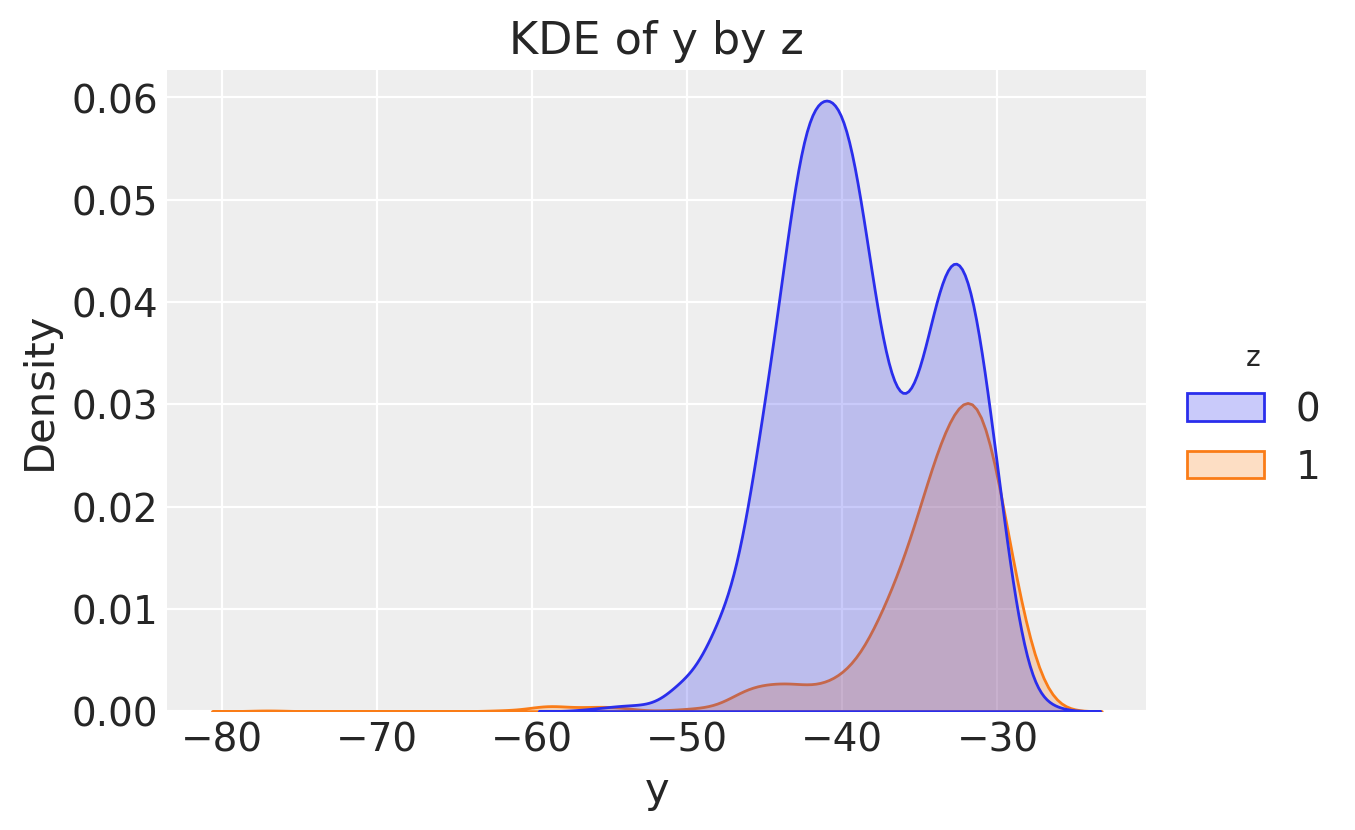

In [8]:
plt.figure(figsize=(6,4))
sns.displot(
    zy_1_df,
    x="y",
    hue="z",
    kind="kde",
    fill=True,
    height=4, aspect=1.5
)
plt.title("KDE of y by z")
plt.show()

/var/folders/sm/x55wx2_x691c2_y5vd95x3cr0000gn/T/ipykernel_90565/967952592.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


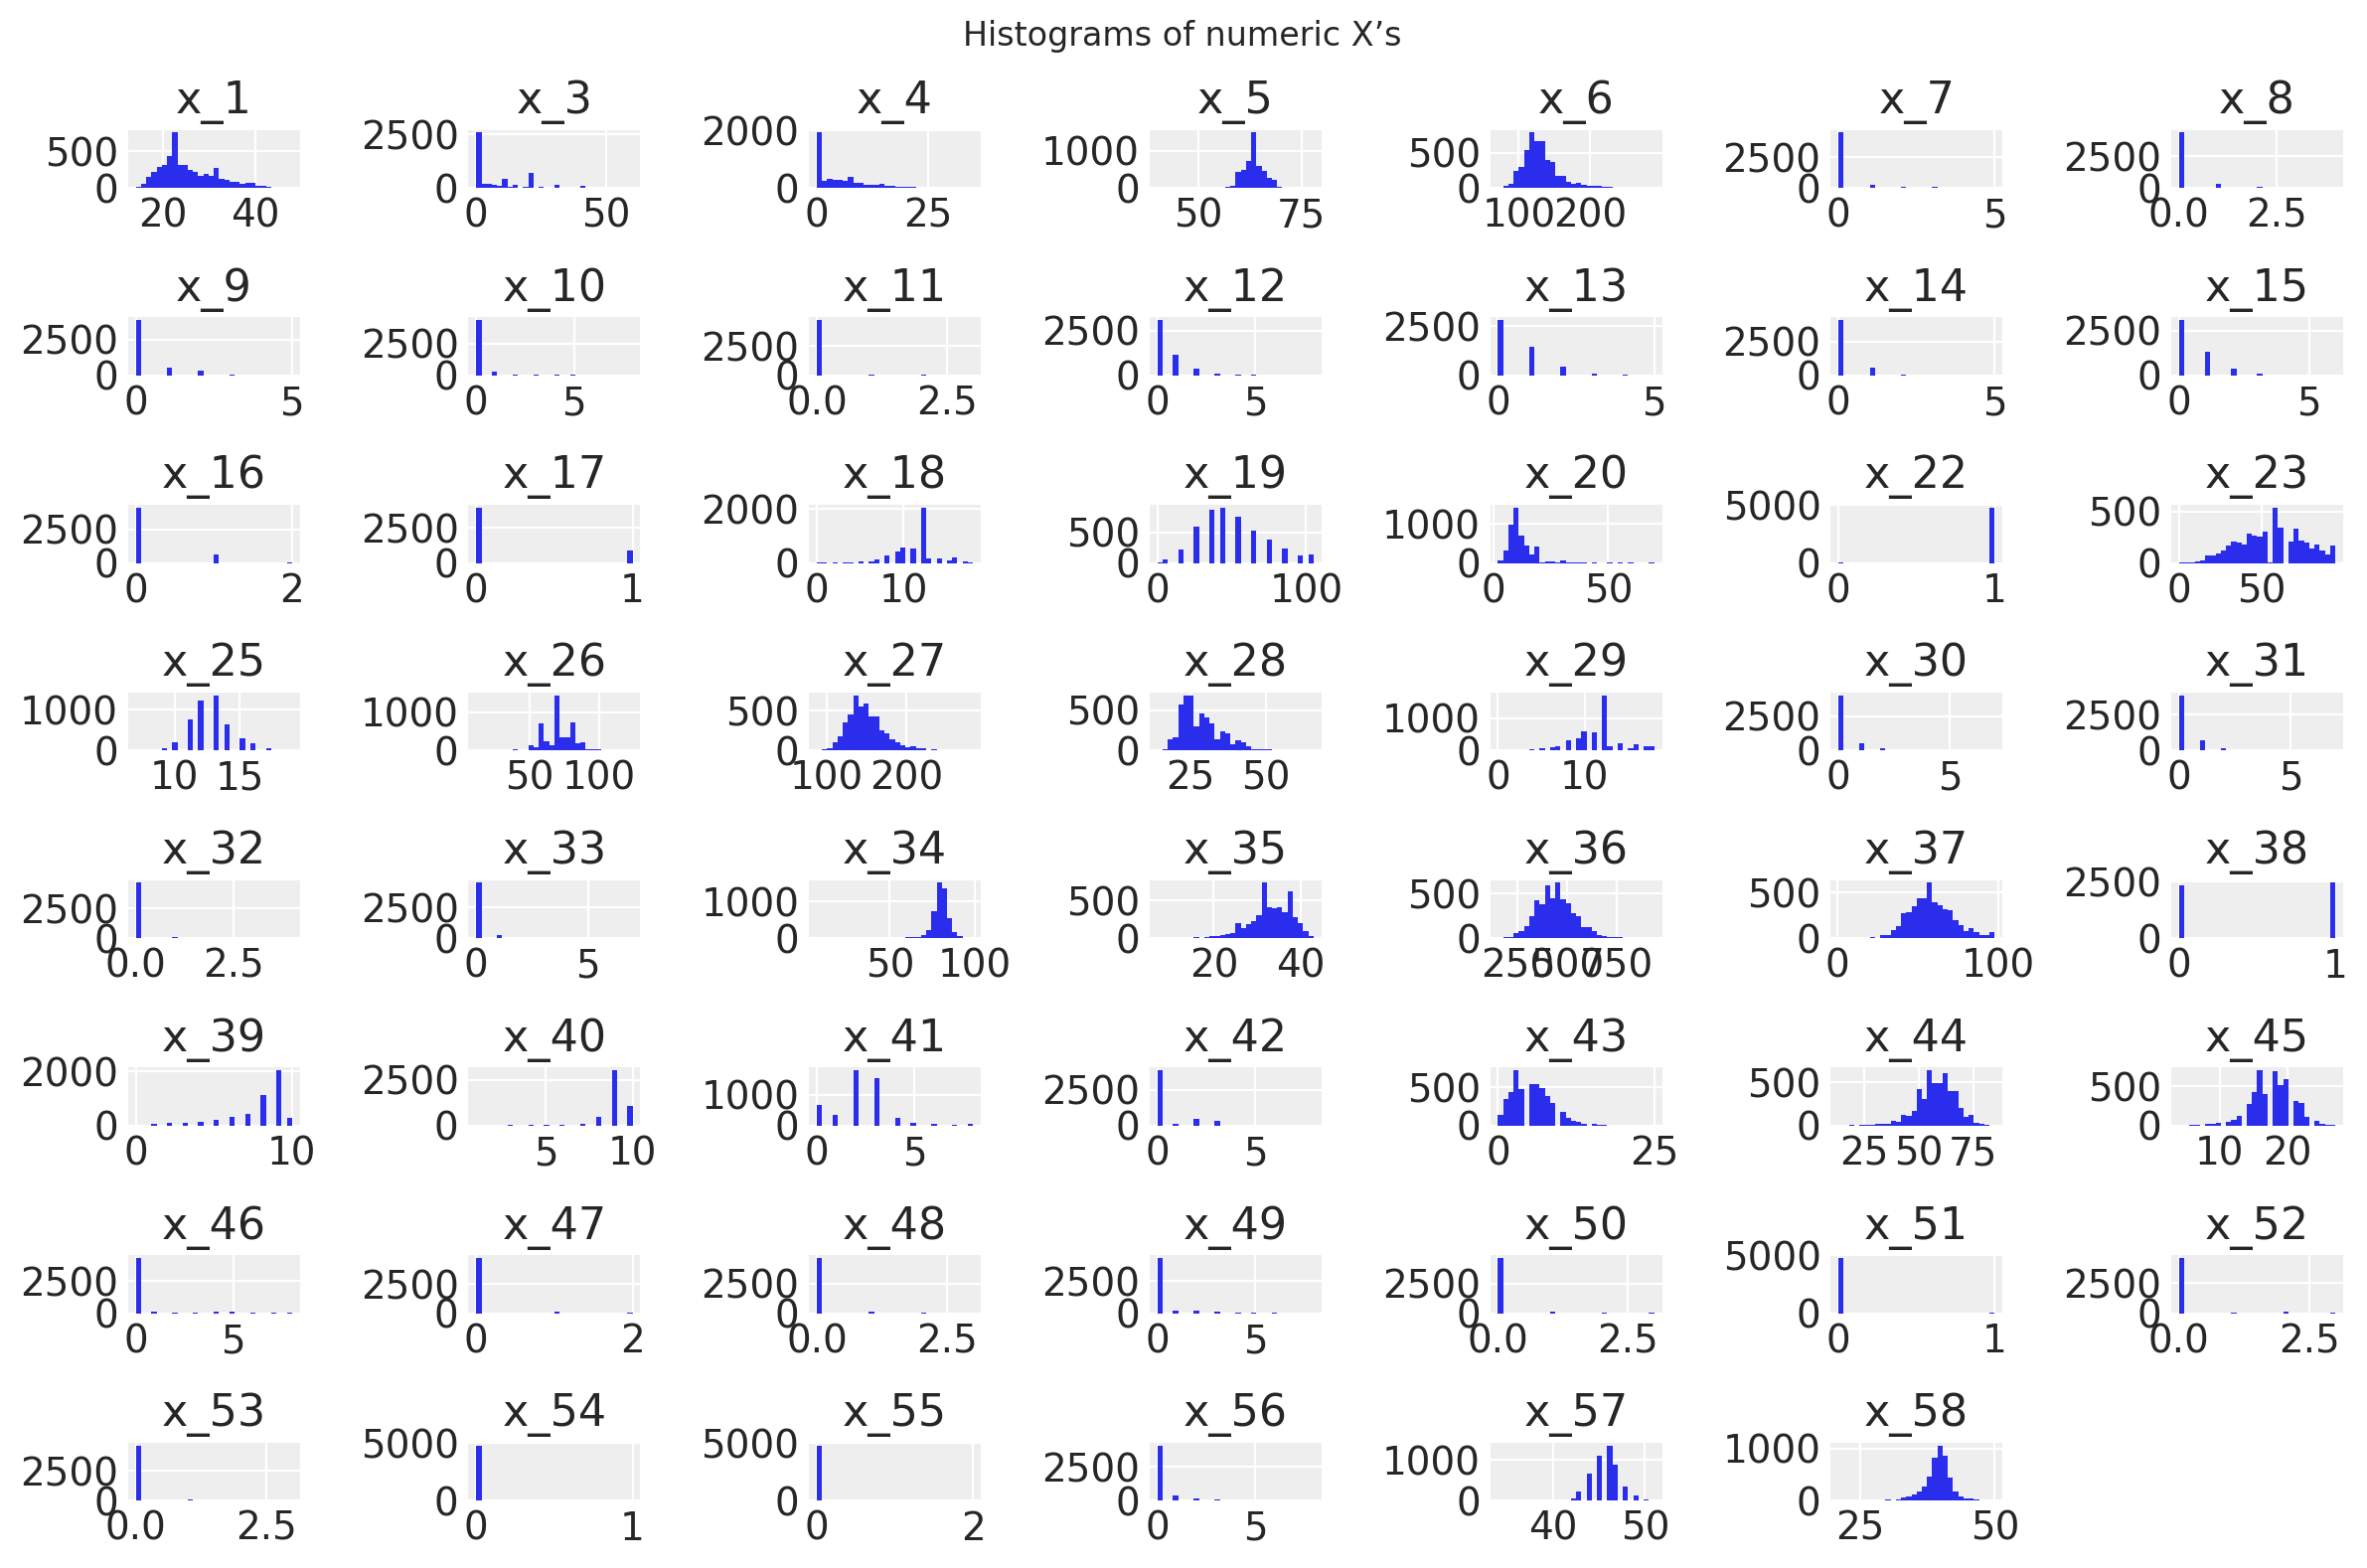

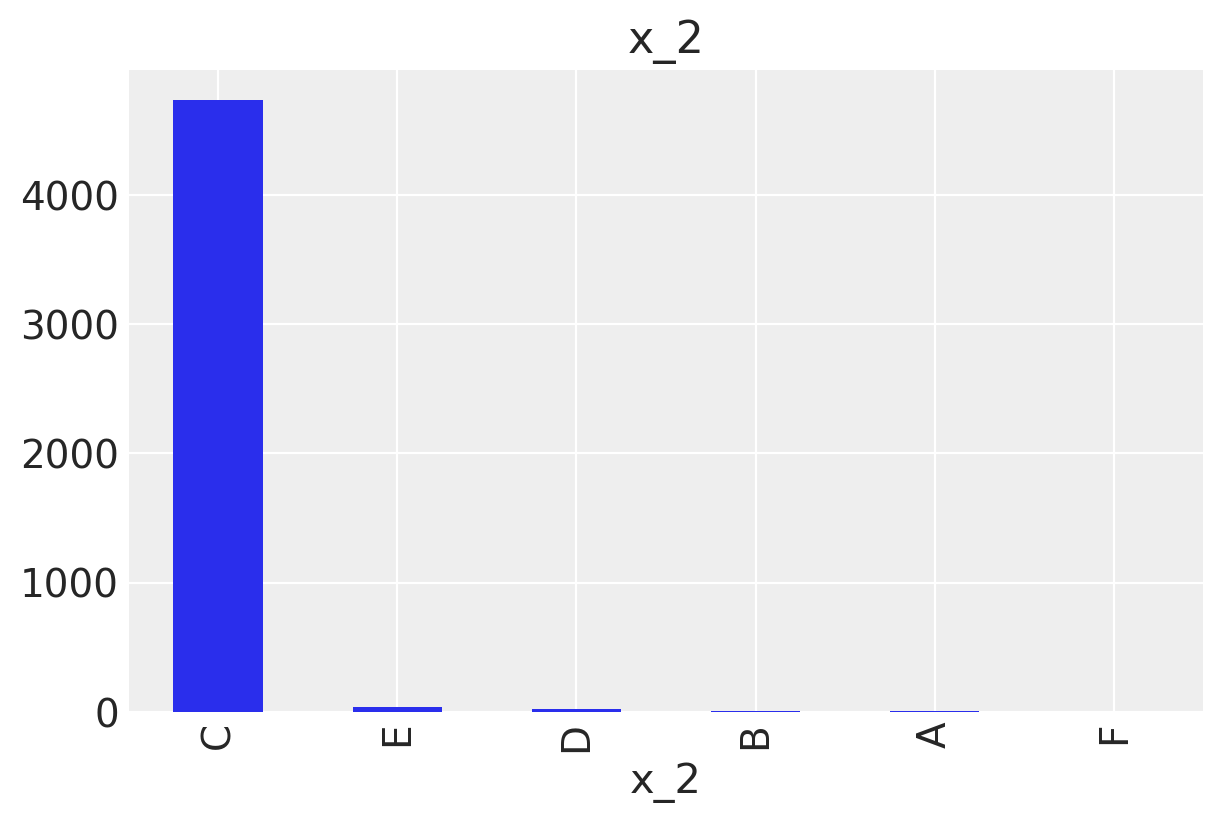

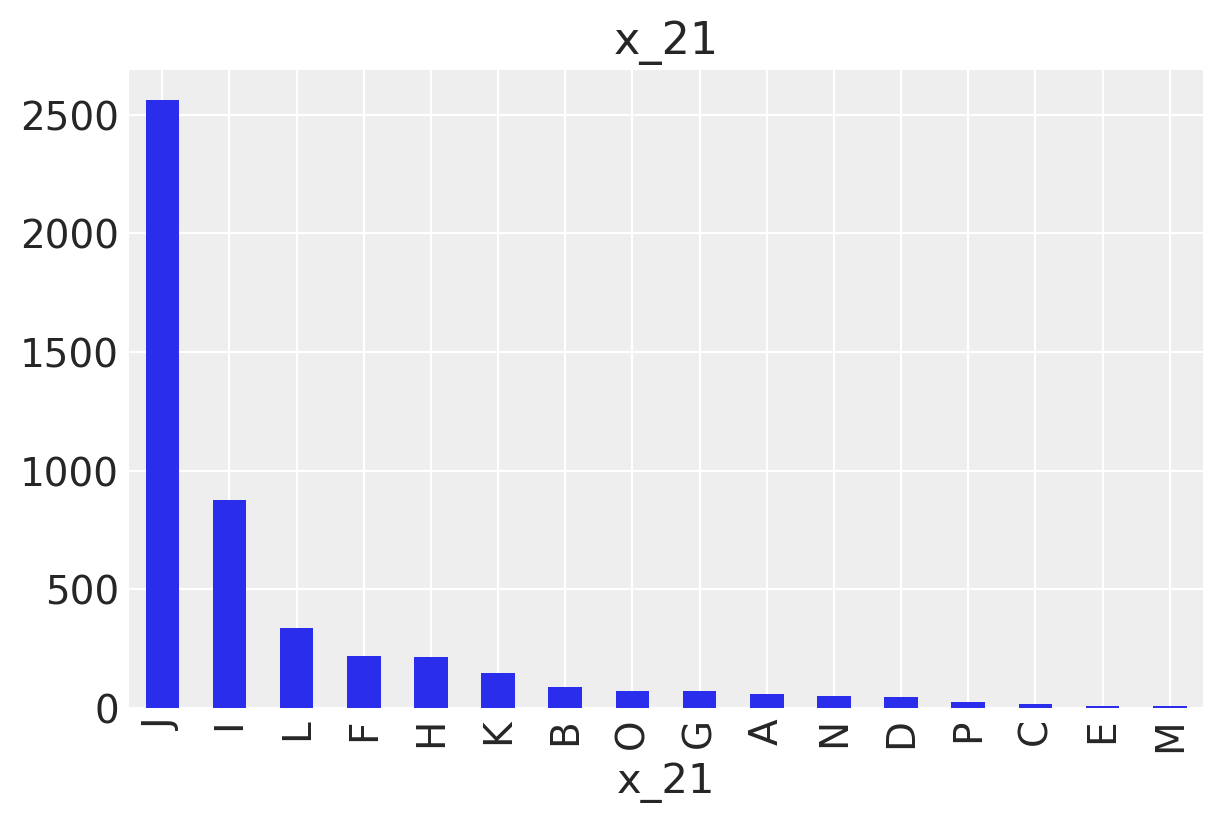

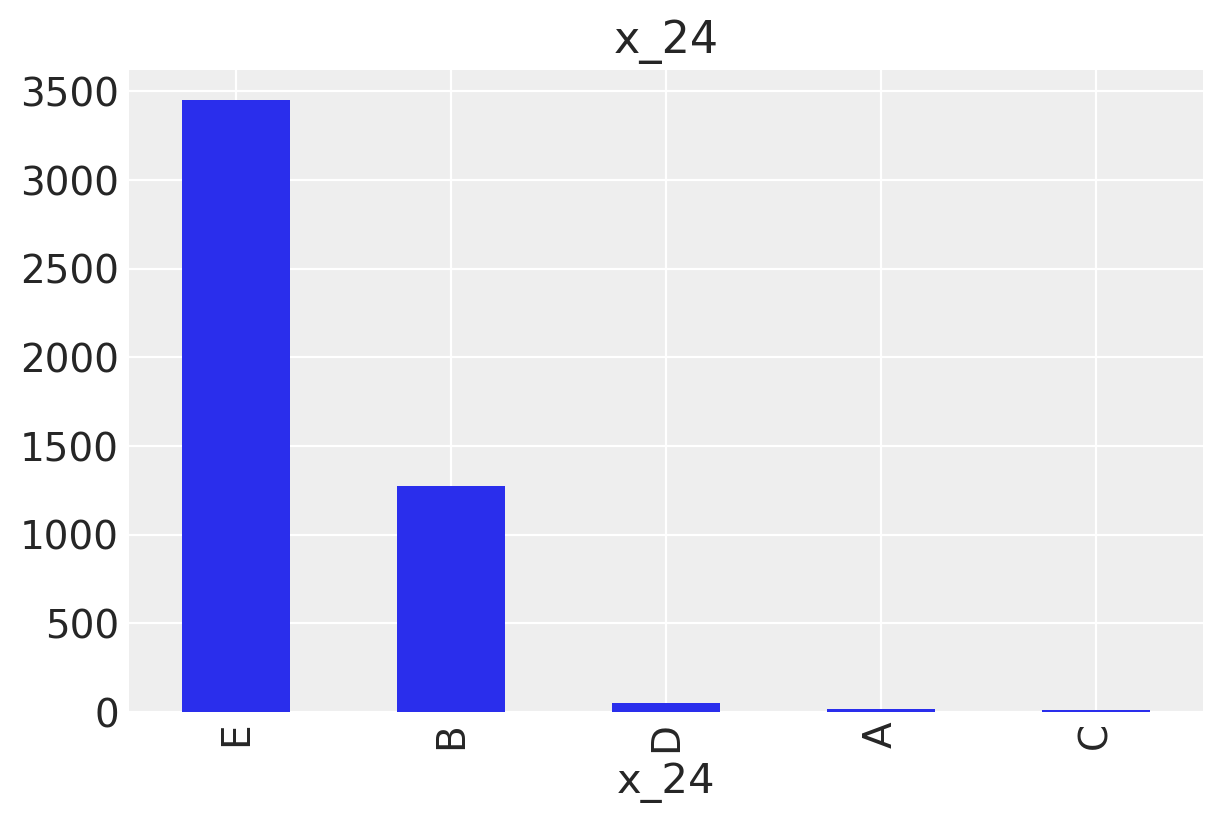

In [16]:
# numeric columns
num_cols = x_df.select_dtypes(include='number').columns
x_df[num_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Histograms of numeric X’s")
plt.tight_layout()
plt.show()

# categorical columns
cat_cols = x_df.select_dtypes(include='object').columns
for col in cat_cols:
    plt.figure(figsize=(6,4))
    x_df[col].value_counts().plot.bar(title=col)
    plt.show()


### Linear Model using OLS

In [18]:
model = OLS(zy_1_df.y, x_df.select_dtypes(include=['number']))

model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              5748.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):                        0.00
Time:                        14:31:47   Log-Likelihood:                         -14143.
No. Observations:                4802   AIC:                                  2.840e+04
Df Residuals:                    4747   BIC:                                  2.875e+04
Df Model:                          55                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x_1            0.1805      0.022      8.292      0.000       0.138       0.223
x_3           -0.0535      0.008     -6.446      0.000      -0.070      -0.037
x_4           -0.3936      0.016    -24.188      0.000      -0.426      -0.362
x_5           -0.0722      0.026     -2.740      0.006      -0.124      -0.021
x_6           -0.0137      0.007     -1.981      0.048      -0.027      -0.000
x_7           -0.1010      0.150     -0.672      0.502      -0.396       0.194
x_8            0.0551      0.165      0.334      0.738      -0.268       0.378
x_9            0.0877      0.105      0.838      0.402      -0.118       0.293
x_10          -0.0057      0.097     -0.059      0.953      -0.196       0.185
x_11           0.3123      0.296      1.056      0.291      -0.268       0.892
x_12           0.0699      0.077      0.908      0.364      -0.081       0.221
x_13          -0.4503      0.092     -4.885      0.000      -0.631      -0.270
x_14           0.0271      0.150      0.181      0.857      -0.267       0.321
x_15          -0.0717      0.095     -0.754      0.451      -0.258       0.115
x_16           0.1411      0.171      0.823      0.410      -0.195       0.477
x_17          -0.0655      0.185     -0.354      0.723      -0.428       0.297
x_18          -0.1070      0.037     -2.920      0.004      -0.179      -0.035
x_19           0.0102      0.005      2.140      0.032       0.001       0.020
x_20           0.0106      0.013      0.823      0.411      -0.015       0.036
x_22          -4.6387      1.105     -4.199      0.000      -6.804      -2.473
x_23          -0.0099      0.008     -1.236      0.216      -0.026       0.006
x_25          -0.0210      0.045     -0.467      0.640      -0.109       0.067
x_26          -0.0180      0.007     -2.703      0.007      -0.031      -0.005
x_27           0.0714      0.007      9.847      0.000       0.057       0.086
x_28           0.0087      0.018      0.485      0.628      -0.027       0.044
x_29           0.0238      0.046      0.517      0.605      -0.067       0.114
x_30           0.0288      0.118      0.244      0.807      -0.203       0.260
x_31           0.0624      0.116      0.536      0.592      -0.166       0.291
x_32           0.0425      0.390      0.109      0.913      -0.723       0.808
x_33           0.5425      0.232      2.336      0.020       0.087       0.998
x_34          -0.1244      0.015     -8.382      0.000      -0.153      -0.095
x_35           0.0417      0.018      2.310      0.021       0.006       0.077
x_36           0.0025      0.001      3.126      0.002       0.001       0.004
x_37           0.0047      0.005      0.879      0.379      -0.006       0.015
x_38           0.1908      0.143      1.336      0.182      -

------
Tip: Random Forest para hacer variable importance. Si no, se puede con 
```python
vi_results = pmb.compute_variable_importance(idata_bikes, μ, X)
pmb.plot_variable_importance(vi_results);
```